This notebook section provides visualizations and analysis of the autoencoder model's performance and outputs. The following cells include:

- Plotting a histogram of reconstruction errors to assess model accuracy.
- Displaying training and validation loss curves to monitor learning progress.
- Visualizing the learned latent space embeddings with a scatter plot.
- Instructions and code for exporting the trained PyTorch model to ONNX format and visualizing its architecture using Netron.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import seaborn as sns
from PyISV.neural_network import NeuralNetwork  # Import your model class

RUN_ID = "20250517_203607"

# Set seaborn style
sns.set_theme(style="whitegrid")

# Common project paths
from PyISV.utils.define_root import PROJECT_ROOT as root_dir

# Paths to the data
data_dir = os.path.join(root_dir, "datasets")
model_dir = os.path.join(root_dir, "models/", RUN_ID)
outputs_dir = os.path.join(model_dir, "outputs")
norms_dir = os.path.join(model_dir, "norms")
stats_dir = os.path.join(model_dir, "stats")

In [ ]:
def run_model(model, model_file, input_file, norm_input=True, norm_output=True):
    checkpoint = torch.load(model_file, map_location="cpu")
    # Only load the model_state_dict if present
    if "model_state_dict" in checkpoint:
        state_dict = checkpoint["model_state_dict"]
    else:
        state_dict = checkpoint

    # Remove 'module.' prefix if present
    new_state_dict = {}
    for k, v in state_dict.items():
        new_key = k.replace("module.", "") if k.startswith("module.") else k
        new_state_dict[new_key] = v

    #missing, unexpected = model.load_state_dict(new_state_dict, strict=False)
    model.eval()

    if input_file.endswith('.npy'):
        inputs = np.load(input_file)
        inputs_tensor = torch.from_numpy(inputs).float()
    elif input_file.endswith('.pt'):
        inputs_tensor = torch.load(input_file)

    with torch.no_grad():
        outputs, latent = model(inputs_tensor)

    if not norm_input:
        subval = np.load(f'{norms_dir}/subval_inputs.npy')
        divval = np.load(f'{norms_dir}/divval_inputs.npy')
        inputs_tensor = inputs_tensor * divval + subval
    if not norm_output:
        subval = np.load(f'{norms_dir}/subval_targets.npy')
        divval = np.load(f'{norms_dir}/divval_targets.npy')
        outputs = outputs * divval + subval

    return inputs_tensor.numpy(), outputs.numpy(), latent.numpy()

In [ ]:
from PyISV.utils.set_architecture import import_config

params = import_config(f"{model_dir}/config.json")
model = NeuralNetwork(params['MODEL'])
reshaped_input, outputs, latent = run_model(
    model=model,
    model_file=f"{model_dir}/model.pt",
    input_file=f"{outputs_dir}/input_validation_data.pt"
)

(1, 320) (1, 320)


/scratch_local/ipykernel_194234/3481623185.py:42: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  outputs_denorm = outputs * divval + subval


Inputs shape: (14400, 1, 320)
Outputs shape: (14336, 1, 320)


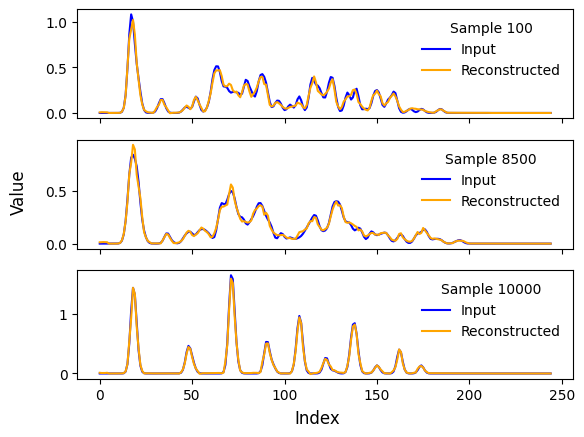

In [ ]:
def plot_reconstructed_vs_input(inputs, outputs, sample_idx, norm_input=False, norm_output=False):
    if not norm_input:
        subval = np.load(f'{norms_dir}/subval_inputs.npy')
        divval = np.load(f'{norms_dir}/divval_inputs.npy')
        inputs = inputs * divval + subval
    if not norm_output:
        subval = np.load(f'{norms_dir}/subval_targets.npy')
        divval = np.load(f'{norms_dir}/divval_targets.npy')
        outputs = outputs * divval + subval

    fig, axes = plt.subplots(len(sample_idx), 1, sharex=True, figsize=(8, 2.5*len(sample_idx)))
    if len(sample_idx) == 1:
        axes = [axes]
    for ax, idx in zip(axes, sample_idx):
        sns.lineplot(x=np.arange(inputs.shape[-1])[25:-50], y=inputs[idx, 0, 25:-50], label="Input", color="blue", ax=ax)
        sns.lineplot(x=np.arange(outputs.shape[-1])[25:-50], y=outputs[idx, 0, 25:-50], label="Reconstructed", color="orange", ax=ax)
        ax.legend(title=f"Sample {idx}", loc="upper right", frameon=False)
        ax.set_xlabel("")
        ax.set_ylabel("")
    fig.supylabel("Value")
    fig.supxlabel("Index")
    plt.tight_layout()

inputs = torch.load(f"{outputs_dir}/input_validation_data.pt").numpy()
outputs = torch.load(f"{outputs_dir}/outputs_validation_data.pt").numpy()
print(f"Inputs shape: {inputs.shape}")
print(f"Outputs shape: {outputs.shape}")

plot_reconstructed_vs_input(inputs, outputs, [100, 8500, 10000])


[0.0578555  0.0578551  0.05785531 ... 0.01698635 0.01865483 0.01639217]


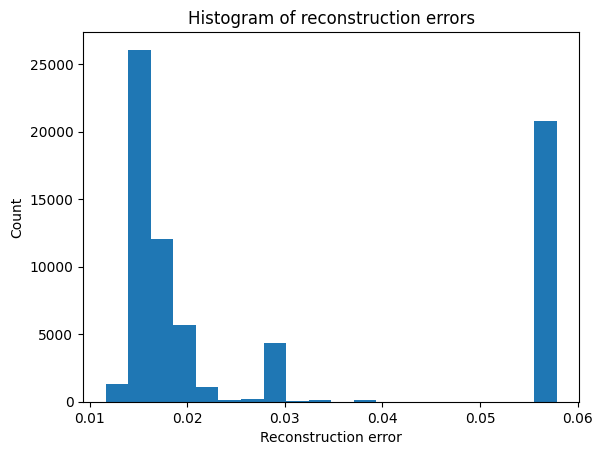

In [ ]:
def reconstruction_errors(recon_errors_file, bins=50):
    """
    Plot the histogram of reconstruction errors using seaborn.
    """
    errors = np.load(recon_errors_file)
    print(errors)
    fig, ax = plt.subplots(1,1, figsize=(7,4))
    sns.histplot(errors, bins=bins, kde=True, ax=ax, color="skyblue")
    ax.set_xlabel('Reconstruction error'); ax.set_ylabel('Count')
    ax.set_title('Histogram of reconstruction errors')
    plt.show()

reconstruction_errors(
    os.path.join(f'{model_dir}/evaluation', f'reconstructed_errors.npy'),
    bins=20
)

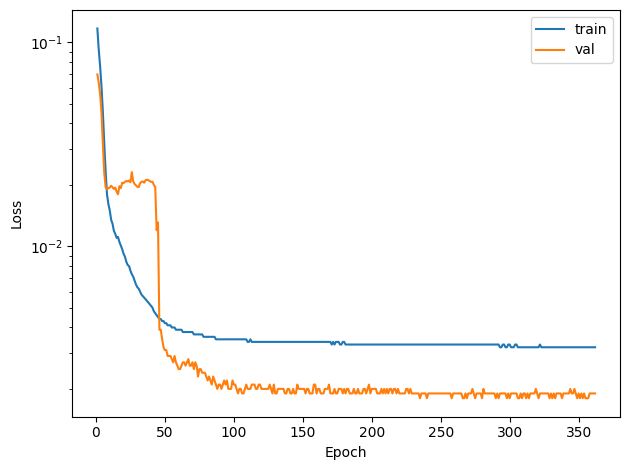

In [ ]:
def plot_loss_curve(stats_file):
    """
    Plot the training and validation loss curves from a CSV file using seaborn.
    """
    df = pd.read_csv(stats_file)
    fig, ax = plt.subplots(1,1, figsize=(7,4))
    sns.lineplot(x=df['epoch'], y=df['train_loss'], label='train', ax=ax)
    sns.lineplot(x=df['epoch'], y=df['val_loss'], label='val', ax=ax)
    ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
    ax.legend()
    ax.set_yscale('log')
    plt.tight_layout()

plot_loss_curve(
    os.path.join(f'{stats_dir}', f'stats.dat')
)

Embeddings shape: (72000, 2)


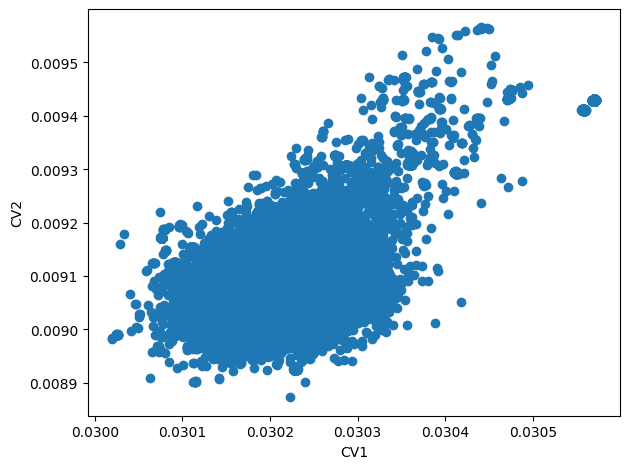

In [ ]:
def embedding_scatter(embedding_file):
    if embedding_file.endswith('.pt'):
        embeddings = torch.load(embedding_file)
        if hasattr(embeddings, 'cpu'):
            embeddings = embeddings.cpu()
        if hasattr(embeddings, 'numpy'):
            embeddings = embeddings.numpy()
    elif embedding_file.endswith('.npy'):
        embeddings = np.load(embedding_file)
    else:
        raise ValueError('Unsupported file type for embeddings.')

    # If embeddings are 3D (e.g., [N,1,2]), squeeze to [N,2]
    print(f"Embeddings shape: {embeddings.shape}")
    if hasattr(embeddings, 'ndim') and embeddings.ndim > 2:
        embeddings = np.squeeze(embeddings)

    fig, ax = plt.subplots(1, 1, figsize=(7,6))
    sns.scatterplot(x=embeddings[:, 0], y=embeddings[:, 1], ax=ax, s=30, color="purple", edgecolor="w", alpha=0.7)
    ax.set_xlabel('CV1'); ax.set_ylabel('CV2')
    plt.tight_layout()

embedding_scatter(
    os.path.join(f'{model_dir}/evaluation', f'embeddings.npy')
)

## Export PyTorch Model to ONNX and Visualize with Netron

This section demonstrates how to export your trained PyTorch model to the ONNX format and visualize its architecture using Netron.



**Steps:**

1. Load your model class and weights.

2. Create a dummy input tensor matching your model's input shape.

3. Export the model to ONNX.

4. Visualize the ONNX file with Netron.



> **Note:** You must have the model class definition available in the notebook. If it's in another file, import it accordingly. Adjust the dummy input shape if your model expects a different input.

In [ ]:
# Visualize with Netron
# Can be installed via pip: pip install netron
# or conda: conda install -c conda-forge netron
import netron

onnx_path = f"{model_dir}/model.onnx"
netron.start(onnx_path)
# This will open a browser window with the model visualization.